In [1]:
import h5py
import sys
import time
sys.path.append("/users/munozr/mycodes")
import numpy as np
from pylab import *
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import GetVars_Plot2d as GVar
from data_analysis_codes.tools import LinData
from matplotlib.collections import LineCollection
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)

ModuleNotFoundError: No module named 'scipy'

In [2]:
param = RRead.read_parameters('pflrw_d3e2_L1206_t1_N32_EdS_GRH_spin_CPunc_MR')
Lin = LinData.LinData_Class(param)
all_h5it = RRead.collect_h5iteration(Lin.param)
all_h5it = all_h5it[0::2]

 read time file


256
32 0 256 8
58 12 244 4
45 84 174 2
29 114 143 1


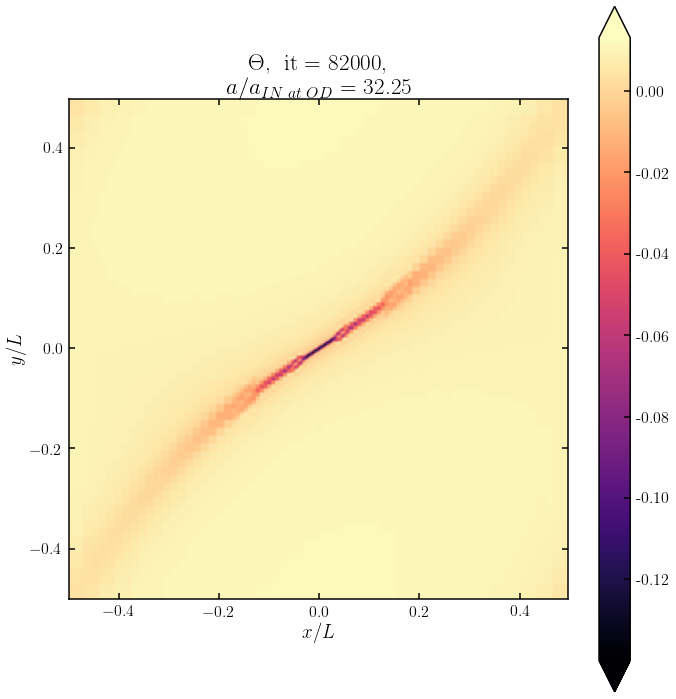

In [7]:
L = 1206
s = 185
cent = 0.0

allit = np.append(np.arange(0, 73600, 200), 
                  np.arange(73800, 120000, 200))

for it in [41000]:#RRead.progressbar(allit):#allit:
    f = h5py.File(param['h5datapath']+param['simname']+'_it_{:06d}.hdf5'.format(it),'r')
    d0 = np.array(f['COFLUID::theta it={:06d} rl=0'.format(it)])
    d1 = np.array(f['COFLUID::theta it={:06d} rl=1'.format(it)])[3:-3, 3:-3, 3:-3]
    d2 = np.array(f['COFLUID::theta it={:06d} rl=2'.format(it)])[3:-3, 3:-3, 3:-3]
    d3 = np.array(f['COFLUID::theta it={:06d} rl=3'.format(it)])[3:-3, 3:-3, 3:-3]
    data = [d0, d1, d2, d3]
    tauOD = np.array(f['COSMOLAPSE::tau it={} tl=0 rl=0'.format(it)])[16,16,16]
    f.close()
    
    
    
    
    

    N = [np.shape(d)[0] for d in data]
    dx = L/N[0]

    xbig = np.arange(-L/2, L/2, dx/(2**(len(data)-1))) / L
    Nbig = len(xbig)
    big_data = np.zeros((Nbig, Nbig, Nbig))
    print(Nbig)
    for rl in range(len(data)):
        dxg = dx/(2**rl)
        Lg = N[rl]*dxg
        xmin = (-Lg/2 + (dxg/2)*(N[rl]%2))/L
        imin = np.argmin(abs(xbig - xmin))
        nrepeat = 2**(3-rl)
        imax = imin + N[rl]*nrepeat
        big_data[imin:imax, imin:imax, imin:imax] = np.repeat(np.repeat(np.repeat(
            data[rl], nrepeat, axis=0), nrepeat, axis=1), nrepeat, axis=2)
        print(N[rl], imin, imax, nrepeat)
    #big_data = np.log(abs(big_data))
    
    #vmin = np.max([np.min(big_data), -9.99])
    vmin = np.min(big_data)
    vmax = np.max(big_data)

    plt.figure(figsize=(10,10))
    
    plt.pcolormesh(xbig, xbig, big_data[:,:,int(Nbig/2)], 
                   vmin=vmin, vmax=vmax, shading='gouraud')
    
    plt.colorbar(format='%.2f', extend='both')
    plt.xlabel(r'$x/L$')
    plt.ylabel(r'$y/L$')
    #plt.title(r'$\log(|\Theta|)$,$\;$ it = {},$\;$ '.format(it)
    #          + '\n' + r'$a/a_{IN \; at \; OD}$ = ' + '{:.2f}'.format(Lin32.an_initial(tauOD)))
    plt.title(r'$\Theta$,$\;$ it = {},$\;$ '.format(it)
              + '\n' + r'$a/a_{IN \; at \; OD}$ = ' + '{:.2f}'.format(Lin.an_initial(tauOD)))
              
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    
    #plt.savefig('/users/munozr/simulations/' + param['simname'] + '/Theta_it={:06d}'.format(it))
    #plt.close(plt.gcf())

256
32 0 256 8
58 12 244 4
45 84 174 2
29 114 143 1


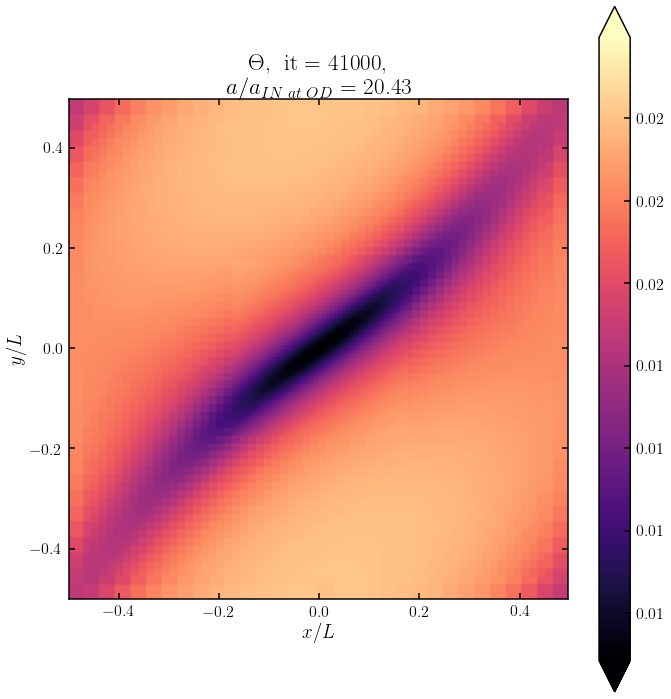

In [4]:
L = 1206
s = 185
cent = 0.0

allit = np.append(np.arange(0, 73600, 200), 
                  np.arange(73800, 120000, 200))

def gk(f, var, it, rl):
    data = RRead.fixij(
        np.array(f['ADMBASE::'+var+' it={} tl=0 rl={}'.format(it, rl)]))
    if rl>0:
        data = data[3:-3, 3:-3, 3:-3]
    return data

def gv2d(f, var, it, rl):
    kxy = gk(f, var+'xy', it, rl)
    kxz = gk(f, var+'xz', it, rl)
    kyz = gk(f, var+'yz', it, rl)
    Kdown = np.array([[gk(f, var+'xx', it, rl), kxy, kxz], 
                      [kxy, gk(f, var+'yy', it, rl), K23], 
                      [kxz, k, gk(f, var+'zz', it, rl)]])
    return Kdown

def gv(f, it, rl):
    
    # spatial metric
    gdown = gv2d(f, 'g', it, rl)
    gup = RRead.inv3(gdown)
    gdet = RRead.det3(gdown)
    
    # extrinsic curvature terms    
    Kdown = gv2d(f, 'k', it, rl)
    Kup = np.einsum('ia...,jb...,ab... -> ij...', gup, gup, Kdown)
    K = np.einsum('ij...,ij... -> ...', gup, Kdown)
    
    # coordinates
    # whole box with smallest refinement
    dxbig = param['dx']/(2**(param['max_refinement_levels']-1))
    xbig = np.arange(-param['Lx']/2, param['Lx']/2, dxbig)
    # current data grid
    Ng = np.shape(K)[0]
    dxg = param['dx']/(2**rl)
    Lg = Ng*dxg
    xmin = -Lg/2 + (dxg/2)*(Ng%2)
    xmax = xbig[np.argmin(abs(xbig - xmin)) + Ng*(2**(3-rl))]
    xarray = np.arange(xmin, xmax, dxg)
    d3xc, d3yc, d3zc = np.meshgrid(xarray, xarray, xarray, indexing='ij')
    
    # Levi Civita tensor
    LC = np.sqrt(gdet) * RRead.LeviCivita3symbol(np.shape(K))
    
    # data
    Kterm =  Kup - RRead.kronecker_delta(3, np.shape(K))*K
    data = np.einsum('ijk...,j...,kl...->i...', LC, x, Kterm)

for it in [41000]:#RRead.progressbar(allit):#allit:
    f = h5py.File(param['h5datapath']+param['simname']+'_it_{:06d}.hdf5'.format(it),'r')
    d0 = np.array(f['COFLUID::theta it={:06d} rl=0'.format(it)])
    d1 = np.array(f['COFLUID::theta it={:06d} rl=1'.format(it)])[3:-3, 3:-3, 3:-3]
    d2 = np.array(f['COFLUID::theta it={:06d} rl=2'.format(it)])[3:-3, 3:-3, 3:-3]
    d3 = np.array(f['COFLUID::theta it={:06d} rl=3'.format(it)])[3:-3, 3:-3, 3:-3]
    data = [d0, d1, d2, d3]
    tauOD = np.array(f['COSMOLAPSE::tau it={} tl=0 rl=0'.format(it)])[16,16,16]
    f.close()

    N = [np.shape(d)[0] for d in data]
    dx = L/N[0]

    xbig = np.arange(-L/2, L/2, dx/(2**(len(data)-1))) / L
    Nbig = len(xbig)
    big_data = np.zeros((Nbig, Nbig, Nbig))
    print(Nbig)
    for rl in range(len(data)):
        dxg = dx/(2**rl)
        Lg = N[rl]*dxg
        xmin = (-Lg/2 + (dxg/2)*(N[rl]%2))/L
        imin = np.argmin(abs(xbig - xmin))
        nrepeat = 2**(3-rl)
        imax = imin + N[rl]*nrepeat
        big_data[imin:imax, imin:imax, imin:imax] = np.repeat(np.repeat(np.repeat(
            data[rl], nrepeat, axis=0), nrepeat, axis=1), nrepeat, axis=2)
        print(N[rl], imin, imax, nrepeat)
    #big_data = np.log(abs(big_data))
    
    #vmin = np.max([np.min(big_data), -9.99])
    vmin = np.min(big_data)
    vmax = np.max(big_data)

    plt.figure(figsize=(10,10))
    
    plt.pcolormesh(xbig, xbig, big_data[:,:,int(Nbig/2)], 
                   vmin=vmin, vmax=vmax, shading='gouraud')
    
    plt.colorbar(format='%.2f', extend='both')
    plt.xlabel(r'$x/L$')
    plt.ylabel(r'$y/L$')
    #plt.title(r'$\log(|\Theta|)$,$\;$ it = {},$\;$ '.format(it)
    #          + '\n' + r'$a/a_{IN \; at \; OD}$ = ' + '{:.2f}'.format(Lin32.an_initial(tauOD)))
    plt.title(r'$\Theta$,$\;$ it = {},$\;$ '.format(it)
              + '\n' + r'$a/a_{IN \; at \; OD}$ = ' + '{:.2f}'.format(Lin.an_initial(tauOD)))
              
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    
    #plt.savefig('/users/munozr/simulations/' + param['simname'] + '/Theta_it={:06d}'.format(it))
    #plt.close(plt.gcf())